In [27]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pyplot
import random
from confmat import plot_confusion_matrix

### Chargement du modèle d'encodage

In [40]:
emb_model = KeyedVectors.load("models/w2vec_model_d300_global_Min")
dim = 300

def encode(msg, model, dim):
    """
    Encode un message
    msg : liste de chaînes de caractères correspondant aux mots du message
    model : le modèle utilisé pour l'encodage
    dim : la dimension des vecteurs mots dans ce modèle
    Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
    Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
    """
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

### Chargement du jeu de données

In [11]:
data_hate = pd.read_pickle("data_hate.pkl")

In [12]:
tweets = data_hate['clean_tweet_min']
sentiment = data_hate['sentiment']

### Équilibrer le jeu de données à la hache

In [13]:
h = 0
n = 0
for i in sentiment:
    if (i==0) : n+=1
    elif (i==1) : h+=1

In [14]:
nlist = []
hlist = []
for i, m in enumerate(data_hate['clean_tweet_min']):
    if (data_hate['sentiment'][i] == 1):
        hlist.append((m, 1))
    else:
        nlist.append((m, 0))

In [42]:
len(hlist)

3193

In [15]:
hsample = random.Random(0).sample(hlist, len(nlist))

In [16]:
balanced_dataset = hsample + nlist
random.Random(0).shuffle(balanced_dataset)

In [17]:
dataset = []
sentiment = []
for m, lab in balanced_dataset:
    dataset.append(m.split())
    sentiment.append(lab)

### Encodage

In [18]:
%%time
dataset_encoded = np.array([encode(msg, emb_model, dim) for msg in dataset])

CPU times: user 76.7 ms, sys: 0 ns, total: 76.7 ms
Wall time: 76.4 ms


In [19]:
sentiment = np.array(sentiment)

### Séparation des données d'entraînement et de test

In [20]:
x_train, x_test, y_train, y_test = train_test_split(dataset_encoded, sentiment, test_size=0.2, random_state=0)

### Construction du modèle

In [141]:
model = keras.Sequential()
model.add(keras.layers.Input(shape = (300,) ))
model.add(keras.layers.Dense(256, activation = "relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256, activation = "relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256, activation = "relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation = "relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation = "relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

In [142]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [143]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 256)               77056     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 64)               

#### Création d'un callback permettant de sauvegarder le meilleur modèle

In [144]:
savemodel_callback = keras.callbacks.ModelCheckpoint(filepath="validation_DNN_model_2022_06_23_4", verbose=0, save_best_only=True)

### Entraînement

In [145]:
%%time

history = model.fit(x_train,
                    y_train,
                    epochs          = 50,
                    batch_size      = 1313,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6964 - accuracy: 0.4752 - val_loss: 0.6892 - val_accuracy: 0.6201
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.6913 - accuracy: 0.5347 - val_loss: 0.6859 - val_accuracy: 0.6140
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.6877 - accuracy: 0.5659 - val_loss: 0.6812 - val_accuracy: 0.6231
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.6853 - accuracy: 0.5765 - val_loss: 0.6753 - val_accuracy: 0.6565
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.6809 - accuracy: 0.5819 - val_loss: 0.6670 - val_accuracy: 0.6596
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.6740 - accuracy: 0.6078 - val_loss: 0.6566 - val_accuracy: 0.6596
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 0.6689 - accuracy: 0.6078 - val_loss: 0.6465 - val_accuracy: 0.6505
Epoch 8/50
1/1 [=========================

### Historique de l'entraînement

On remarque le suraprentissage à partir de l'epoch 20-25.

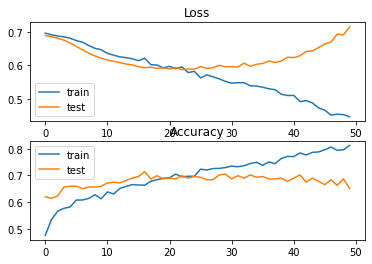

In [146]:
# Graphique de la fonction de perte
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# Graphique de l'accuracy
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Matrice de confusion du dernier modèle

In [147]:
pred = model.predict(x_test)

In [148]:
norm_pred = np.array([0 if e < 0.5 else 1 for e in pred ])

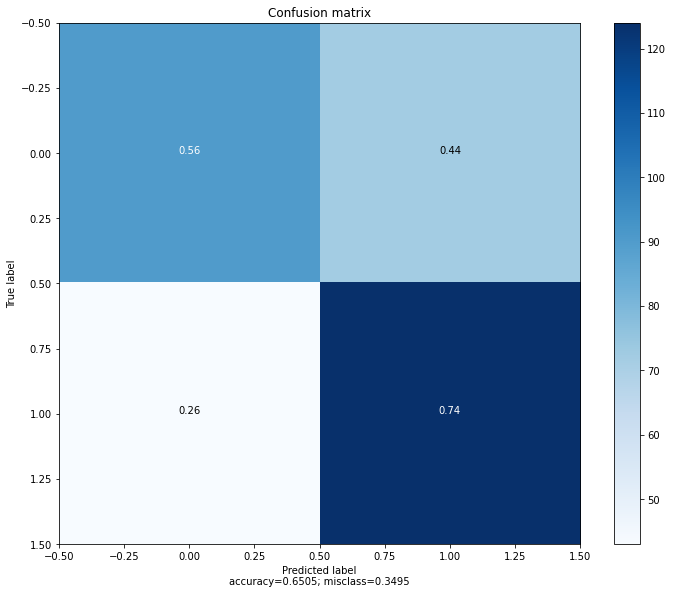

In [149]:
plot_confusion_matrix(y_test, norm_pred, target_names=None)

### Chargement du meilleur modèle et impression de sa matrice de confusion

In [150]:
load_model = keras.models.load_model("validation_DNN_model_2022_06_23_4")

In [151]:
lpred = load_model.predict(x_test)

In [152]:
norm_lpred = np.array([0 if e < 0.5 else 1 for e in lpred ])

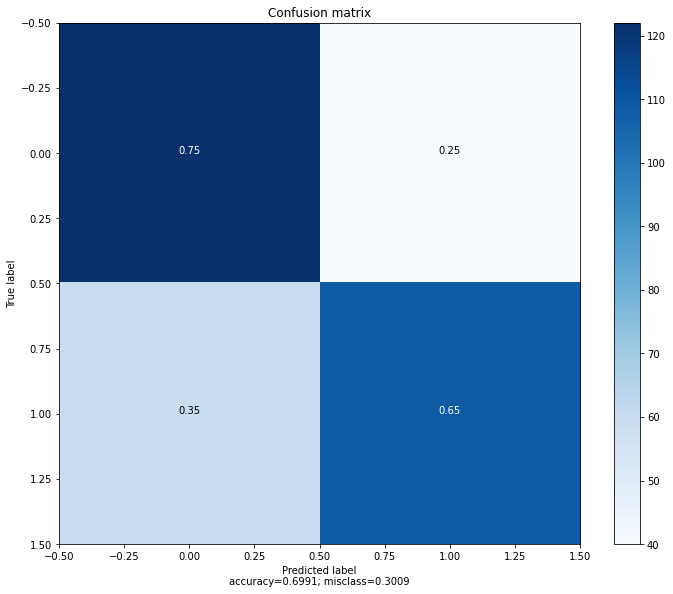

In [153]:
plot_confusion_matrix(y_test, norm_lpred, target_names=None)